In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import sys, os
sys.path.append(os.path.abspath('../src'))
from dataset import get_dataloaders
from model import LSTMForecaster

In [2]:
# Load data
X = np.load('../data/X.npy')  
y = np.load('../data/y.npy')

In [14]:
# Tạo DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, test_loader = get_dataloaders(
    X, y,
    batch_size=32,
    split_ratio=0.8,
    shuffle_train=True,
    device=device
)

**Tao Model, loss&optimizer**

In [18]:
input_size = X.shape[2]
hidden_size = 126  
num_layers = 2
pred_len = y.shape[1]
lr = 1e-3

In [19]:
model = LSTMForecaster(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    pred_len=pred_len
).to(device)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

**Train**

In [21]:
num_epochs = 50
train_losses = []
val_losses   = []

for epoch in range(1, num_epochs+1):
    # Training
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            running_val_loss += criterion(y_pred, y_batch).item() * X_batch.size(0)
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # In ra kết quả mỗi epoch
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  Train Loss: {epoch_train_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")

Epoch 01  Train Loss: 0.1976  Val Loss: 0.0097
Epoch 05  Train Loss: 0.0037  Val Loss: 0.0105
Epoch 10  Train Loss: 0.0027  Val Loss: 0.0077
Epoch 15  Train Loss: 0.0027  Val Loss: 0.0069
Epoch 20  Train Loss: 0.0025  Val Loss: 0.0064
Epoch 25  Train Loss: 0.0023  Val Loss: 0.0067
Epoch 30  Train Loss: 0.0023  Val Loss: 0.0061
Epoch 35  Train Loss: 0.0022  Val Loss: 0.0059
Epoch 40  Train Loss: 0.0022  Val Loss: 0.0057
Epoch 45  Train Loss: 0.0020  Val Loss: 0.0065
Epoch 50  Train Loss: 0.0020  Val Loss: 0.0054


**Plot loss Curve**

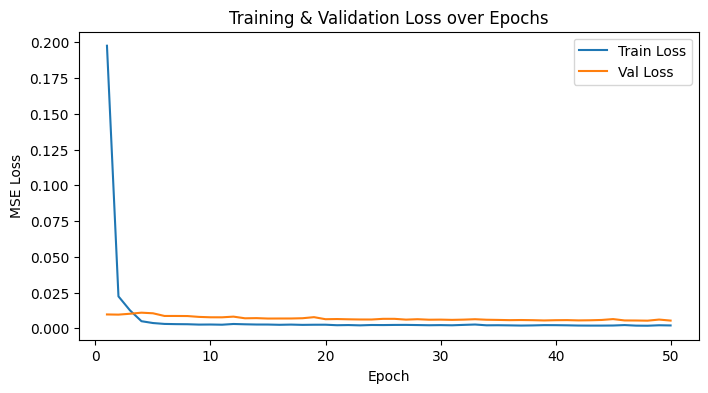

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.show()

In [28]:
torch.save(model.state_dict(), '../models/lstm_forecaster.pth')
print("Saved model to ../models/lstm_forecaster.pth")

Saved model to ../models/lstm_forecaster.pth


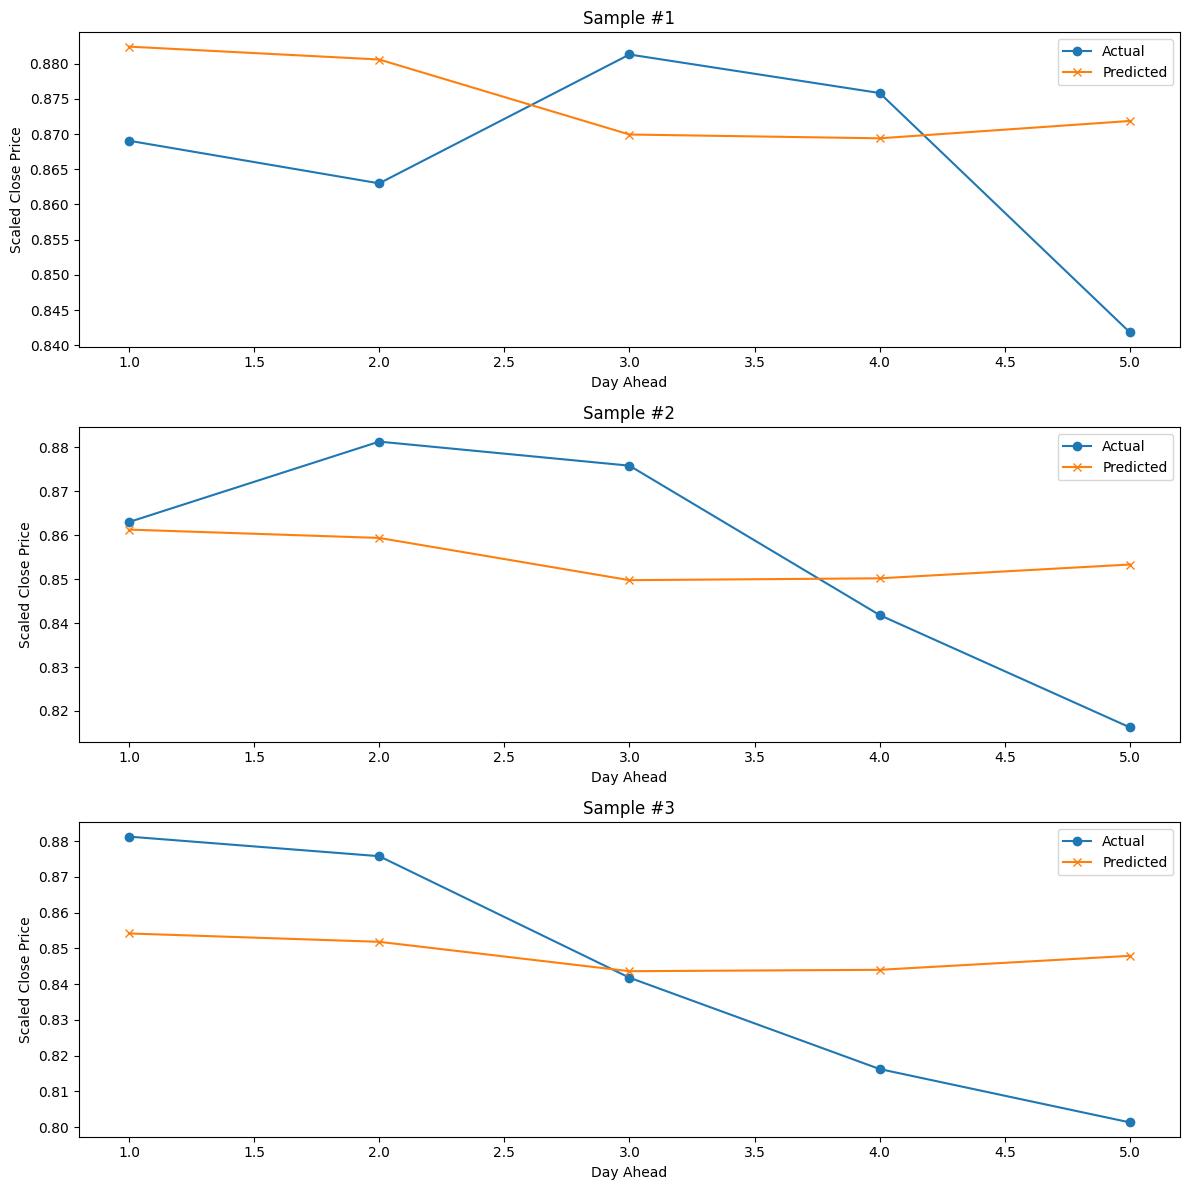

In [23]:
# 1. Đảm bảo model đang ở chế độ eval và đã load weights
model.eval()
# Nếu bạn restart kernel, nhớ load lại state_dict:
# model.load_state_dict(torch.load('../models/lstm_forecaster.pth', map_location=device))

# 2. Tạo mảng chứa dự đoán và thực tế
all_preds = []
all_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # X_batch: (batch, seq_len, input_size)
        # y_batch: (batch, pred_len)
        preds = model(X_batch).cpu().numpy()    # (batch, pred_len)
        trues = y_batch.cpu().numpy()
        all_preds.append(preds)
        all_trues.append(trues)

# 3. Chuyển sang shape (n_samples, pred_len)
all_preds = np.vstack(all_preds)
all_trues = np.vstack(all_trues)

# 4. Nếu bạn muốn vẽ cho tất cả samples (có thể quá nhiều), thường ta chọn 1–3 sample đầu
n_plot = 3
days = np.arange(1, all_preds.shape[1] + 1)

plt.figure(figsize=(12, 4 * n_plot))
for i in range(n_plot):
    plt.subplot(n_plot, 1, i+1)
    plt.plot(days, all_trues[i], marker='o', label='Actual')
    plt.plot(days, all_preds[i], marker='x', label='Predicted')
    plt.title(f'Sample #{i+1}')
    plt.xlabel('Day Ahead')
    plt.ylabel('Scaled Close Price')
    plt.legend()

plt.tight_layout()

In [24]:
y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

y_true = np.concatenate(y_true_list, axis=0)   # [N, pred_len]
y_pred = np.concatenate(y_pred_list, axis=0)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Chuyển thành dạng phẳng nếu chỉ dự đoán 1 bước
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100  # tránh chia 0

print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAE : {mae:.4f}")
print(f"📊 MAPE: {mape:.2f}%")


📊 RMSE: 0.0737
📊 MAE : 0.0590
📊 MAPE: 7.99%


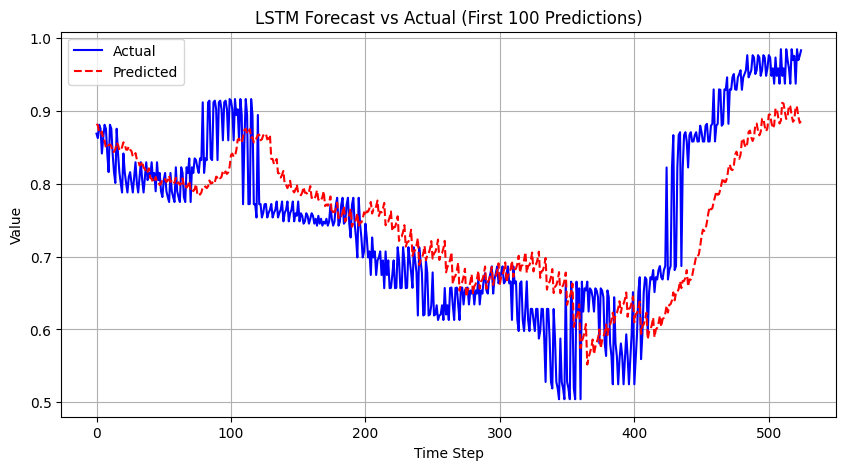

In [27]:
plt.figure(figsize=(10,5))
plt.plot(y_true_flat, label='Actual', color='blue')
plt.plot(y_pred_flat, label='Predicted', color='red', linestyle='--')
plt.title('LSTM Forecast vs Actual (First 100 Predictions)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
